In [2]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import utils.wbpdn.wbpdn_lcurve as lc
import utils.numerical_differentiation.trend_filter_cvx as tfilter
from scipy import interpolate
from scipy import signal
import csv

from sklearn.preprocessing import PolynomialFeatures

from scipy.linalg import lstsq
from scipy.integrate import odeint

import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

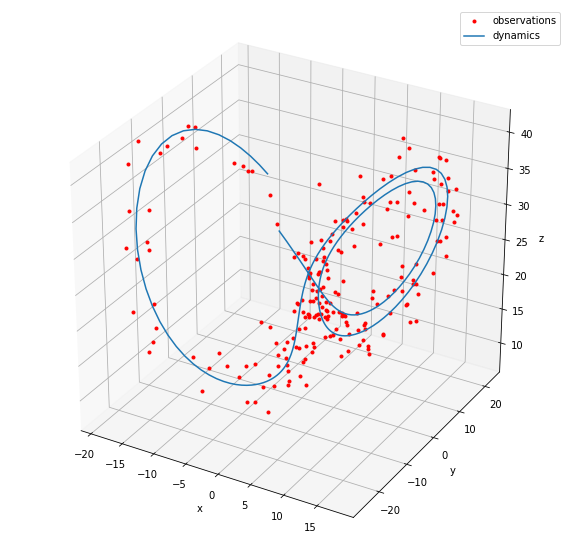

In [3]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def lorenz63(x, t, sigma=10, rho=28, beta=8/3):
    return [
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    ]

sig=10
rho=28
beta=8/3


####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 2.2  # start and end
dt = 0.01  # time step
n_times = int(np.floor((tf-t0)/dt)+ 1)  #Number of time instances

n_states = 3 #Number of state variables
t_span = np.linspace(t0, tf, n_times)

x0 = [-8, 7, 27]
X = odeint(lorenz63, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]
x3 = X[:,2]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = sig * (x2 - x1)
dX[:,1] =  x1 * (rho - x3) - x2
dX[:,2] = x1 * x2 - beta * x3

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 2
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]
y3 = Y[:,2]

#Plot dynamical system and observations
plt.figure(figsize = (10,10))
ax = plt.axes(projection="3d")
ax.plot3D(y1,y2,y3,'r.')
ax.plot3D(x1[1:],x2[1:],x3[1:])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(['observations','dynamics'])
plt.show()

  Convergence criterion reached in 19 iterations.
  Convergence criterion reached in 19 iterations.
  Convergence criterion reached in 18 iterations.


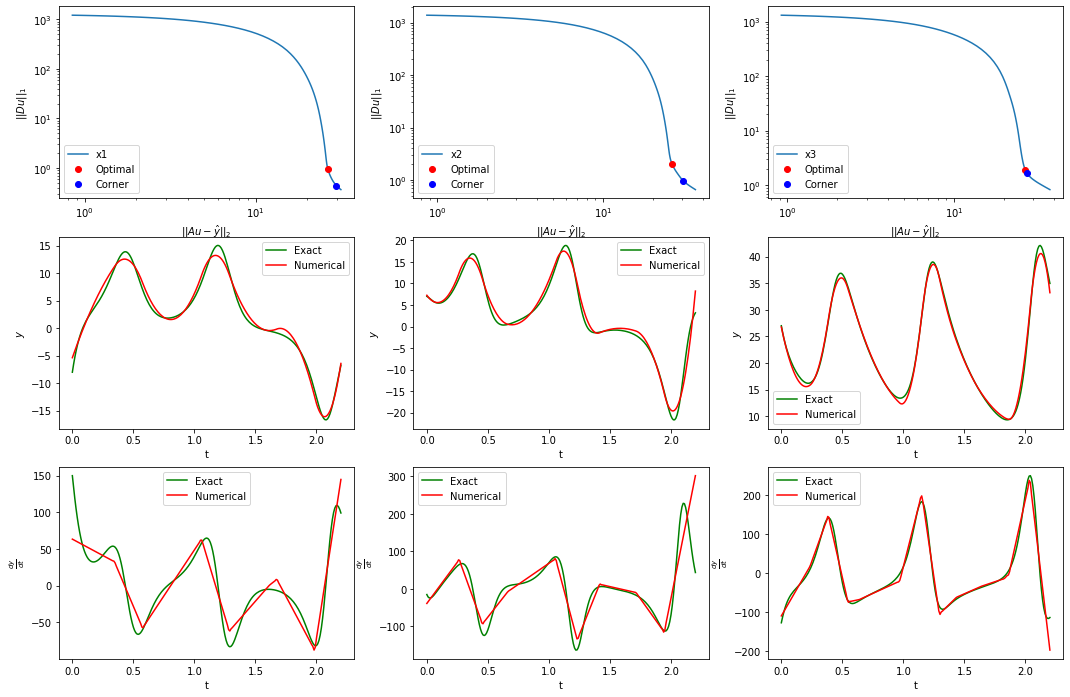

In [6]:
################### DENOISING AND NUMERICAL DIFFERENTIATION - TREND FILTER ###################
Y_tf = np.zeros((m_samples, n_states))
DY_tf = np.zeros((m_samples, n_states))
residual_flc = []
reg_residual_flc = []
res_corner = np.zeros((50,n_states))
reg_res_corner = np.zeros((50,n_states))
fig_tf, axs_tf = plt.subplots(3, n_states, figsize = (18,12))

#CVX code
for state in range(n_states):
    
    #Generate full lcurve
    tf_flc = tfilter.full_lcurve(Y[:,state], order = 3, lambda_min = 1e-2, lambda_max = 1000, normalize = False, plot_lc = False)
    sol_path = tf_flc[0]
    residual_lc, reg_residual_lc = tf_flc[1]
    
    residual_flc.append(residual_lc)
    reg_residual_flc.append(reg_residual_lc)

    sol_error = np.zeros(sol_path.shape[1])
    for i in range(sol_path.shape[1]):
        sol_error[i] = norm(sol_path[:,i] - X[:, state])

    min_indx = np.argmin(sol_error)
    res_min = residual_lc[min_indx]
    reg_min = reg_residual_lc[min_indx]

    #Find corner point
    tf_lc = tfilter.lcurve_corner(Y[:,state], order = 3, lambda_min = 1e-2, lambda_max = 1000)
    Y_tf[:,state] = tf_lc[0]
    res_c, reg_c = tf_lc[3]
    
    res_corner[0:len(res_c)+1,state] = np.append(res_min, np.array(res_c))
    reg_res_corner[0:len(reg_c)+1,state] = np.append(reg_min, np.array(reg_c))
    
    y_tf_ss = interpolate.splrep(t, Y_tf[:,state], k=3, s=0)
    DY_tf[:,state] = interpolate.splev(t, y_tf_ss, der=1)

    axs_tf[0][state].loglog(residual_lc, reg_residual_lc)
    axs_tf[0][state].loglog(res_min, reg_min,'ro')
    axs_tf[0][state].loglog(res_c[-1], reg_c[-1],'bo')
    axs_tf[0][state].set_xlabel(r'$||Au - \hat{y}||_2$')
    axs_tf[0][state].set_ylabel(r'$||Du||_1$')
    axs_tf[0][state].legend([f'x{state+1}','Optimal', 'Corner'])
    
    axs_tf[1][state].plot(t, X[:,state],'g')
    axs_tf[1][state].plot(t, Y_tf[:,state],'r')
    axs_tf[1][state].set_xlabel('t')
    axs_tf[1][state].set_ylabel(r'$y$')
    axs_tf[1][state].legend(['Exact', 'Numerical'])
    
    axs_tf[2][state].plot(t, dX[:,state],'g')
    axs_tf[2][state].plot(t, DY_tf[:,state],'r')
    axs_tf[2][state].set_xlabel('t')
    axs_tf[2][state].set_ylabel(r'$\frac{dy}{dt}$')
    axs_tf[2][state].legend(['Exact', 'Numerical'])

#Remove ends
trim = int(np.floor(5 / 100 * m_samples))
Y_t = Y[trim:-trim,:]
Yhat_tf = Y_tf[trim:-trim,:]
DYhat_tf = DY_tf[trim:-trim,:]
X_tf = X[trim:-trim,:]
DX_tf = dX[trim:-trim,:]

In [7]:
#Compute errors
error_X = np.zeros(n_states)
error_dX = np.zeros(n_states)

for state in range(n_states):
    
    error_X[state] = norm(Yhat_tf[:,state] - X_tf[:,state]) / norm(X_tf[:,state])
    error_dX[state] = norm(DYhat_tf[:,state] - DX_tf[:,state]) / norm(DX_tf[:,state])

errors = pd.DataFrame(np.array([error_X, error_dX]).T, index = ['state 1','state 2','state 3'], columns=['x error','dx error'])
errors

,x error,dx error
state 1,0.110676,0.339823
state 2,0.098278,0.327731
state 3,0.022310,0.126202


In [8]:
filename = "Lorenz63_trendfilter_noise" + str(sigma) + ".csv"
fields = ['x1_true', 'x2_true', 'x3_true','x1_noisy', 'x2_noisy', 'x3_noisy', 'x1', 'x2', 'x3','dx1_true', 'dx2_true', 'dx3_true', 'dx1', 'dx2', 'dx3', ]
data = np.concatenate((X, Y, Y_tf, dX, DY_tf), axis = 1)

# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)   
          
    # writing the fields   
    csvwriter.writerow(fields)   
          
    # writing the data rows   
    csvwriter.writerows(data)
    
filename = "Lorenz63_trendfilter_noise" + str(sigma) + "_full_lcurve" + ".csv"
fields = ['residual x1','residual x2','residual x3','reg. residual x1', 'reg. residual x2', 'reg. residual x3']
data_lcurve = np.vstack((residual_flc[0], residual_flc[1], residual_flc[2], reg_residual_flc[0], reg_residual_flc[1], reg_residual_flc[2])).T

# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)   
          
    # writing the fields   
    csvwriter.writerow(fields)   
          
    # writing the data rows   
    csvwriter.writerows(data_lcurve)
       
filename = "Lorenz63_trendfilter_noise" + str(sigma) + "_lcurve_corner" + ".csv"
fields = ['corner residual x1','corner residual x2','corner residual x3','corner reg. residual x1', 'corner reg. residual x2', 'corner reg. residual x3']
data_corner = np.concatenate((res_corner, reg_res_corner), axis = 1)

# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)   
          
    # writing the fields   
    csvwriter.writerow(fields)   
          
    # writing the data rows   
    csvwriter.writerows(data_corner)
    
filename = "Lorenz63_trendfilter_noise" + str(sigma) + "_errors" + ".csv"
fields = ['x1_error', 'x2_error', 'x3_error', 'dx1_error', 'dx2_error', 'dx3_error']
data_errors = np.hstack((error_X, error_dX))

# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)   
          
    # writing the fields   
    csvwriter.writerow(fields)   
          
    # writing the data rows   
    csvwriter.writerow(data_errors)

In [4]:
################### SET UP LINEAR ALGEBRA PROBLEM ###################
#Model to approximate functions f1 = dx1 and f2 = dx2
poly_d = 3
poly = PolynomialFeatures(poly_d)
Phi = poly.fit_transform(Y_tf)
basis_names = poly.get_feature_names()
p_basis = Phi.shape[1]#Number of basis functions

print(basis_names)

#True coefficients
sol_true = np.zeros((p_basis, n_states))

sol_true[1,0] = -sig
sol_true[2,0] = sig

sol_true[1,1] = rho
sol_true[6,1] = -1
sol_true[2,1] = -1

sol_true[5,2] = 1
sol_true[3,2] = -beta

['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0 x1^2', 'x0 x1 x2', 'x0 x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3']


In [6]:
################### FULL L-CURVE: UNWEIGHTED BPDN  ###################

Beta = np.zeros((p_basis, n_states))
residuals = []
reg_residuals = []
res_min_s = []
reg_min_s = []

fig, axs = plt.subplots(1, 3, figsize = (18,4))

for state in range(n_states):
    
    dy = DY_tf[:,state]
    lc_bpdn = lc.full_lcurve(Phi, dy, lambda_min = 1e-4, lambda_max = 10, n_lambdas = 100, tol = 0, normalize = False, plot_lc = False, verbose = False)
    sol_path = lc_bpdn[0]
    residual_lc, reg_residual_lc = lc_bpdn[1]
    residuals.append(residual_lc)
    reg_residuals.append(reg_residual_lc)
    
    sol_error = np.zeros(sol_path.shape[1])
    for i in range(sol_path.shape[1]):
        sol_error[i] = norm(sol_path[:,i] - sol_true[:, state])
        
    min_indx = np.argmin(sol_error)
    res_min_s.append(residual_lc[min_indx])
    reg_min_s.append(reg_residual_lc[min_indx])
    
    axs[state].plot(residual_lc, reg_residual_lc)
    axs[state].plot(residual_lc[min_indx], reg_residual_lc[min_indx],'ro')
    axs[state].set_xlabel(r'$||\dot{x} - \Phi \xi||_2$')
    axs[state].set_ylabel(r'$||\xi||_1$')
    axs[state].legend([f'x{state+1}','Optimal'])
    
    print(f'Solving for state: {state+1}')

    
################### FIND CORNER POINT: UNWEIGHTED BPDN  ###################

Beta = np.zeros((p_basis, n_states))
lc_data = []
fig2, axs2 = plt.subplots(1, 3, figsize = (18,4))

for state in range(n_states):
    
    dy = DY_tf[:,state]
    lc_bpdn = lc.lcurve_corner(Phi, dy, lambda_min = 1e-4, lambda_max = 10, epsilon = 0.001, max_iter = 50, tol = 1e-8, normalize = False, verbose = False)
    
    res_c, reg_c = lc_bpdn[3]
    Beta[:,state] = lc_bpdn[0]
    
    axs2[state].plot(residuals[state], reg_residuals[state])
    axs2[state].plot(res_min_s[state], reg_min_s[state],'ro')
    axs2[state].plot(res_c[-1], reg_c[-1],'bo')
    axs2[state].set_xlabel(r'$||\dot{x} - \Phi \xi||_2$')
    axs2[state].set_ylabel(r'$||\xi||_1$')
    axs2[state].legend([f'x{state+1}','Optimal', 'Corner'])
    
    print(f'Solving for state: {state+1}')

NameError: name 'p_basis' is not defined

In [6]:
Beta[np.abs(Beta) < 0.1] = 0
Beta

array([[ 0.        , -0.15148806,  0.        ],
       [-7.26534577,  8.04984875,  0.        ],
       [ 8.97896293,  7.14560509,  0.        ],
       [ 0.        ,  0.12199814, -2.52656447],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.95660099],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.22762042,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

Solving for state variable x1.
  Weighted iteration 1.


SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

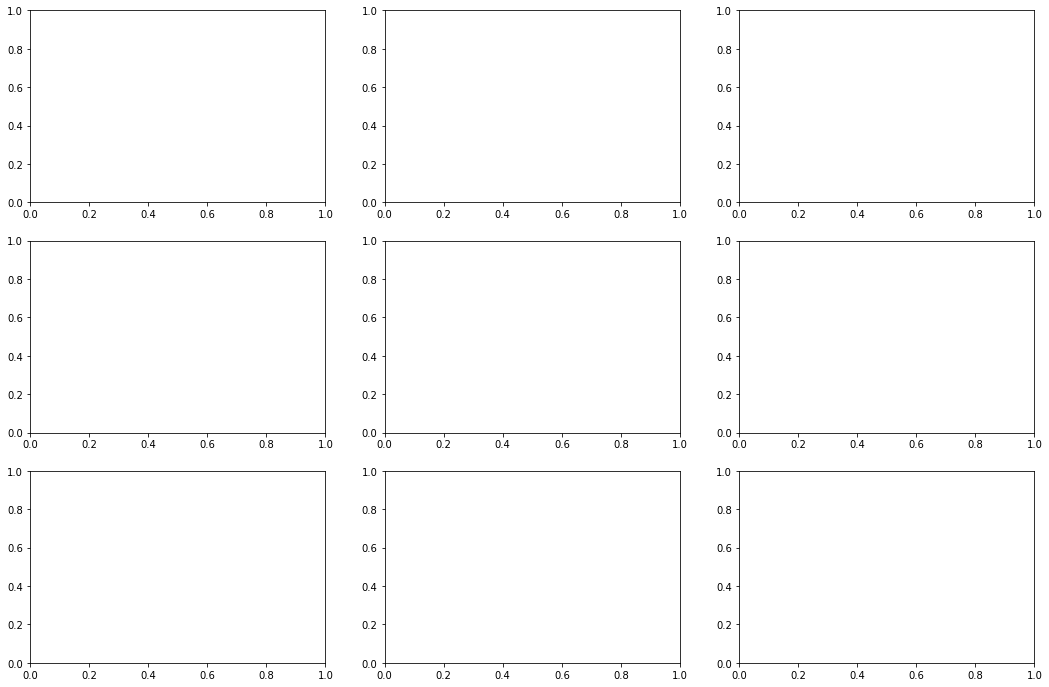

In [8]:
################### WEIGHTED BPDN  ###################
num_itr = 3
q = 2
eps_w = 0.0001
fig_itr, axs_itr = plt.subplots(num_itr, n_states, figsize = (18,12))
Beta_itr = np.zeros((p_basis, n_states, num_itr+1))
Beta_itr[:,:,0] = Beta

for state in range(n_states): 
    
    print(f'Solving for state variable x{state+1}.')
    dy = DY_tf[:,state]
    
    for itr in range(num_itr):
        
        print(f'  Weighted iteration {itr+1}.')

        #Apply weighting
        w = 1 / (np.abs(Beta_itr[:,state, itr]) ** 2 + eps_w)
        
        #Full lcurve
        flc_bpdn = lc.full_lcurve(Phi, dy, w, lambda_min = 1e-6, lambda_max = 10, n_lambdas = 100, tol = 0, normalize = True, plot_lc = False, verbose = False)
        sol_path = flc_bpdn[0]
        residual_lc, reg_residual_lc = flc_bpdn[1]
        residuals = residual_lc 
        reg_residuals = reg_residual_lc 

        sol_error = np.zeros(sol_path.shape[1])
        for i in range(sol_path.shape[1]):
            sol_error[i] = norm(sol_path[:,i] - sol_true[:, state])

        min_indx = np.argmin(sol_error)
        res_min_s = residual_lc[min_indx]
        reg_min_s = reg_residual_lc[min_indx]
        
        #Find corner point
        lc_bpdn = lc.lcurve_corner(Phi, dy, w, lambda_min = 1e-6, lambda_max = 10output = object_name.function_name(, epsilon = 0.001, max_iter = 50, tol = 1e-8, normalize = True, verbose = False)
        res_c, reg_c = lc_bpdn[3]
        Beta_itr[:,state, itr+1] = lc_bpdn[0]
        
        axs_itr[itr][state].plot(residuals, reg_residuals)
        axs_itr[itr][state].plot(res_min_s, reg_min_s,'ro')
        axs_itr[itr][state].plot(res_c[-1], reg_c[-1],'bo')
        axs_itr[itr][state].set_xlabel(r'$||\dot{x} - \Phi \xi||_2$')
        axs_itr[itr][state].set_ylabel(r'$||\xi||_1$')
        axs_itr[itr][state].legend([f'x{state+1}','Optimal', 'Corner'])
        axs_itr[itr][state].set_title(f'Weighted iteration: {itr+1}')        
        
    print('\n')
    


In [17]:
Beta_itr[:,:,-1][np.abs(Beta_itr[:,:,-1]) < 0.1] = 0
Beta_itr[:,:,-1]

array([[  0.        ,   0.        ,   0.        ],
       [-10.00881452,  27.88442772,   0.        ],
       [  9.99528515,  -0.95901167,   0.        ],
       [  0.        ,   0.        ,  -2.67615151],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.0011767 ],
       [  0.        ,  -0.99763713,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     